# 2023 农业系统模型与大数据分析实验课5: 卷积神经网络

## 1. Preparations

In [1]:
import skimage
import math,sys,os,numpy as np
from numpy.linalg import norm
from scipy.ndimage import convolve, correlate
from skimage.measure import block_reduce
from matplotlib import pyplot as plt

import torch
import torchvision
from torchvision import models,transforms,datasets

In [3]:
root_dir = './MNIST/'
torchvision.datasets.MNIST(root=root_dir,download=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 6326538.01it/s] 


Extracting ./MNIST/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 4823432.90it/s]


Extracting ./MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3502211.91it/s]


Extracting ./MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4607141.18it/s]

Extracting ./MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST/
    Split: Train

In [4]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True)
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()
print(images.shape, labels.shape)

(60000, 28, 28) (60000,)


## 2. Data visualization

In [5]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

In [6]:
# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')
plt.gray()
plt.close()

7

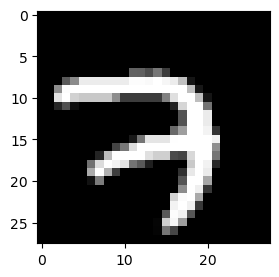

In [7]:
plot(images[5000])
labels[5000]

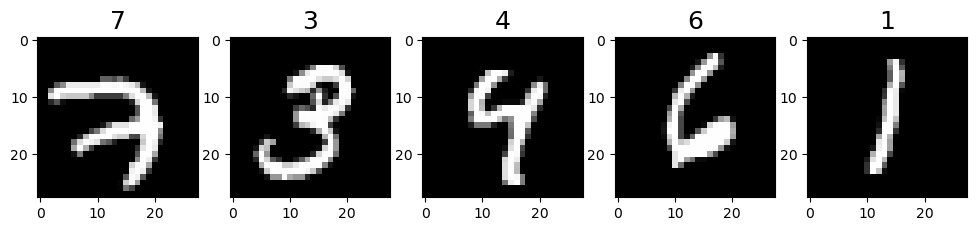

In [8]:
plots(images[5000:5005], titles=labels[5000:5005])

## 3. Filters and convolutions

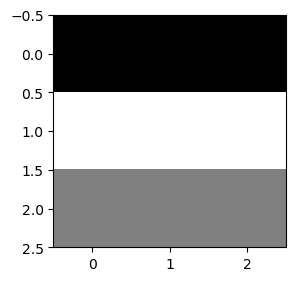

In [9]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]
plot(top)

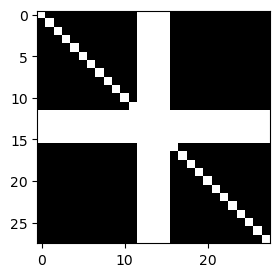

In [10]:
cross = np.zeros((28,28))
cross += np.eye(28)
for i in range(4):
    cross[12+i,:] = np.ones(28)
    cross[:,12+i] = np.ones(28)
plot(cross)

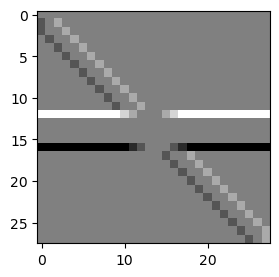

In [11]:
corr_cross = correlate(cross,top) 
plot(corr_cross)

In [12]:
# In some fields, convolution or filtering can be better understood as correlations. 
# In practice we slide the filter matrix over the image (a bigger matrix) always selecting patches from the image with the same size as the filter. 
# We compute the dot product between the filter and the image patch and store the scalar response which reflects the degree of similarity/correlation between the filter and image patch.

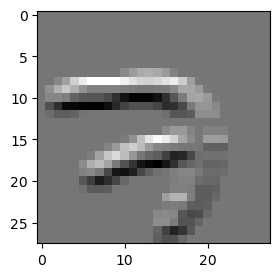

In [13]:
corrtop = correlate(images[5000], top)
plot(corrtop)

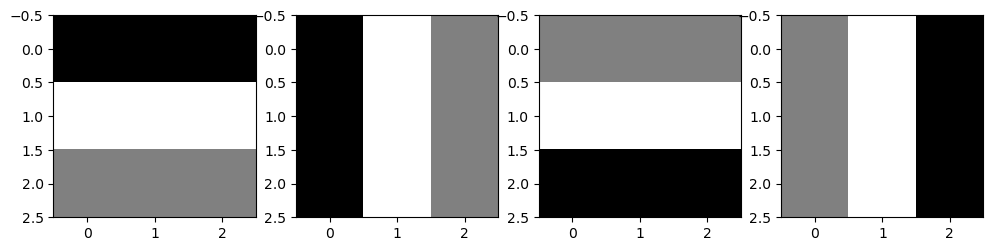

In [14]:
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)

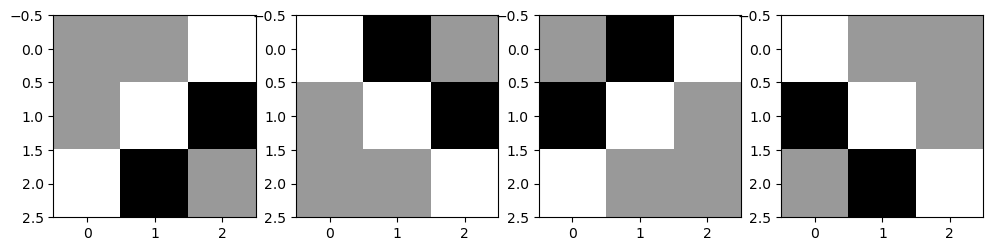

In [15]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

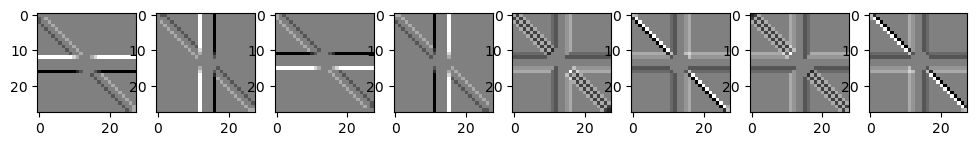

In [16]:
rots = straights + diags
corrs_cross = [correlate(cross, rot) for rot in rots]
plots(corrs_cross)

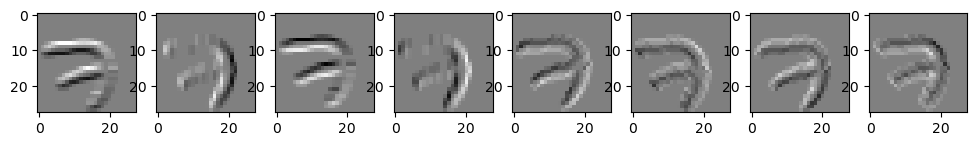

In [17]:
rots = straights + diags
corrs = [correlate(images[5000], rot) for rot in rots]
plots(corrs)

In [18]:
def pool(im): 
    return block_reduce(im, (7,7), np.max)

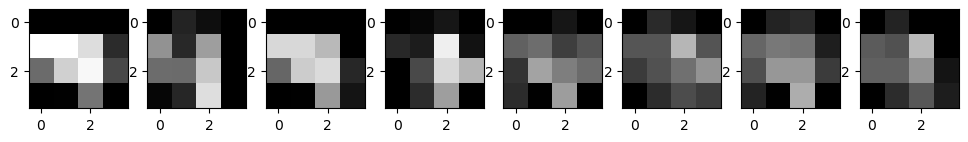

In [19]:
plots([pool(im) for im in corrs])

## 4. A simple classifier

In [23]:
n=len(images)

In [24]:
eights=[images[i] for i in range(n) if labels[i]==8]
ones=[images[i] for i in range(n) if labels[i]==1]
len(eights), len(ones)

(5851, 6742)

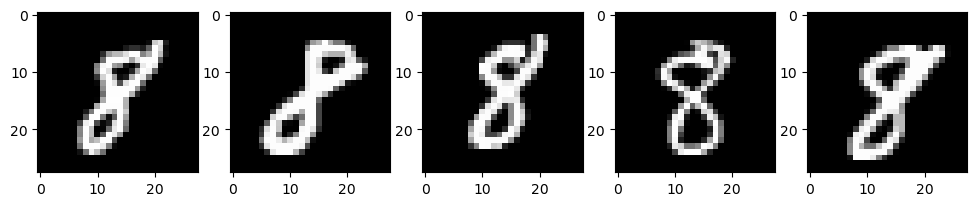

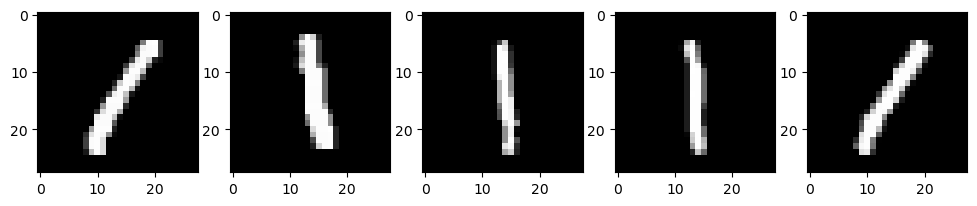

In [25]:
plots(eights[:5])
plots(ones[:5])

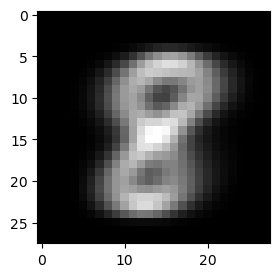

In [26]:
raws8 =  np.mean(eights[1000:],axis=0)
plot(raws8)

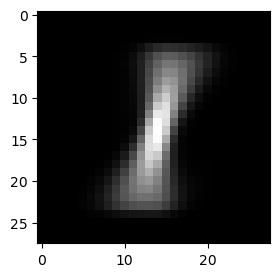

In [27]:
raws1 =  np.mean(ones[1000:],axis=0)
plot(raws1)

In [28]:
# sum of squared errors
def sse(a,b): 
    return ((a-b)**2).sum()

def is8_raw_n2(im): 
    return 1 if sse(im,raws1) > sse(im,raws8) else 0

In [29]:
# 数字8集合中有912个判别成了8，数字1集合中有27个判成了8
[np.array([is8_raw_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[912, 27]

In [31]:
# 数字8集合中有88个判别成了1，数字1集合中有973个判成了1
[np.array([(1-is8_raw_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[88, 973]

In [30]:
# Precision精确率：判断成8的里面正确的个数
# Recall召回率：所有8的样本中被识别出的个数
Precision_8 = 912/(912+27)
Recall_8 = 912/1000
Precision_1 = 973/(973+88)
Recall_1 = 973/1000

print('precision 8:', Precision_8, 'recall 8:', Recall_8)
print('precision 1:', Precision_1, 'recall 1:', Recall_1)
print('accuracy :', (Recall_1+Recall_8)/2)

precision 8: 0.9712460063897763 recall 8: 0.912
precision 1: 0.9170593779453345 recall 1: 0.973
accuracy : 0.9425


In [ ]:
# Building classifier with convolution and pooling

In [32]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights[1000:]]) for rot in rots]
len(pool8), pool8[0].shape

(8, (4851, 4, 4))

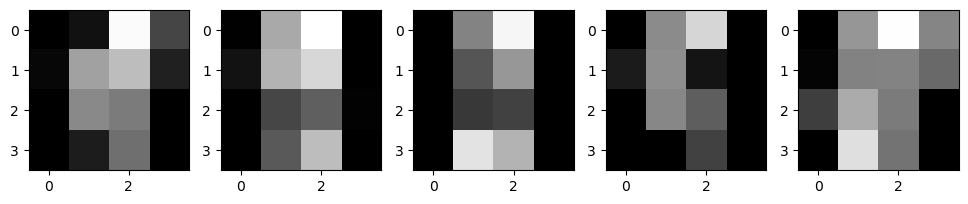

In [33]:
plots(pool8[0][0:5])

In [ ]:
plots([pool8[i][0] for i in range(8)])
plots([pool8[i][1] for i in range(8)])
plots([pool8[i][2] for i in range(8)])
plots([pool8[i][3] for i in range(8)])

In [ ]:
def normalize(arr): 
    return (arr-arr.mean())/arr.std()

In [ ]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])
filts8 = normalize(filts8)

In [ ]:
plots(filts8)

In [ ]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones[1000:]]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

In [ ]:
plots(filts1)

In [ ]:
def pool_corr(im): 
    return np.array([pool(correlate(im, rot)) for rot in rots])

In [ ]:
def is8_n2(im): 
    return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8) else 0

In [ ]:
[np.array([is8_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

In [ ]:
[np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

In [ ]:
Precision_8 = 969/(969+37)
Recall_8 = 969/1000
Precision_1 = 963/(963+31)
Recall_1 = 963/1000

print('precision 8:', Precision_8, 'recall 8:', Recall_8)
print('precision 1:', Precision_1, 'recall 1:', Recall_1)
print('accuracy :', (Recall_1+Recall_8)/2)

## 5. Practicals: improving classification with Convolutional Neural Net

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
# 定义一个卷积神经网络
class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=128, out_features=2)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=7, stride=7)
        x = x.view(-1, 4*4*8)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [34]:
bs = 64 # Batch size，Epoch, Iteration
l8 = np.array(0)
eights_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l8.astype(np.int64))] for e in eights]
l1 = np.array(1)
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l1.astype(np.int64))] for e in ones]
train_dataset = eights_dataset[1000:] + ones_dataset[1000:]
test_dataset = eights_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [35]:
conv_class = classifier()
loss_fn = nn.NLLLoss() # mapping the error between predicted value and ground truth
learning_rate = 1e-3
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr=learning_rate)

In [36]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1):
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0
        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
            outputs = model(inputs)
            loss = loss_fn(outputs,labels) # Loss function
            optimizer.zero_grad() # Optimizer
            loss.backward()  # Backwards
            optimizer.step()
            _,preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels.data.type(torch.LongTensor))
            running_loss += loss.data
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return loss_train, acc_train

In [37]:
l_t, a_t = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0057 Acc: 0.9149
Train - Loss: 0.0018 Acc: 0.9732
Train - Loss: 0.0010 Acc: 0.9843
Train - Loss: 0.0007 Acc: 0.9884
Train - Loss: 0.0006 Acc: 0.9890
Train - Loss: 0.0005 Acc: 0.9900
Train - Loss: 0.0005 Acc: 0.9907
Train - Loss: 0.0004 Acc: 0.9912
Train - Loss: 0.0004 Acc: 0.9914
Train - Loss: 0.0004 Acc: 0.9921


In [39]:
def test(model,data_loader):
    model.train(False)
    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data     
        bs = labels.size(0)
        outputs = model(inputs)
        classes = labels == 1
        loss = loss_fn(outputs,classes.type(torch.LongTensor)) 
        _,preds = torch.max(outputs,1)
        running_corrects += torch.sum(preds == classes.data.type(torch.LongTensor))
        running_loss += loss.data
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [40]:
test(conv_class,test_loader)

Test - Loss: 0.0005 Acc: 0.9890


In [41]:
for m in conv_class.children():
    T_w = m.weight.data.numpy()
    T_b = m.bias.data.numpy()
    break

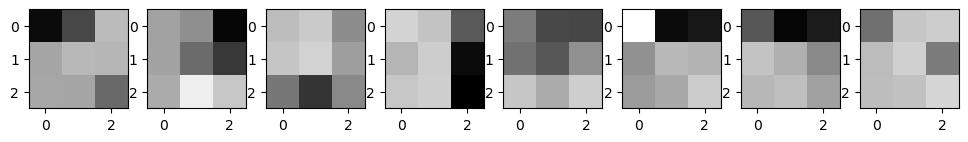

In [42]:
plots([T_w[i][0] for i in range(8)])